In [3]:
%cd ../

/Users/sarchey1/paper/FederatedLearning


In [4]:
import warnings
warnings.simplefilter('ignore')

## Stochastic Block Model Experiment

Before geting into the experiment details, let's review algorithm 1 and the primal and dual updates.

### Algorithm 1

![title](../gradient_federated.png)

In [33]:
# %load algorithm/main.py
from sklearn.metrics import mean_squared_error

from algorithm.penalty import *


def algorithm_1(K, D, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, calculate_score=False):
    '''
    :param K: the number of iterations
    :param D: the block incidence matrix
    :param weight_vec: a list containing the edges's weights of the graph
    :param datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param true_labels: a list containing the true labels of the nodes
    :param samplingset: the sampling set
    :param lambda_lasso: the parameter lambda
    :param penalty_func_name: the name of the penalty function used in the algorithm

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    alpha = 0.12
    E, N = D.shape
    m, n = datapoints[0]['features'].shape

    # starting algorithm 1

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the primal variable of the algorithm 1
    '''

    iteration_scores = []
    for iterk in range(K):
        prev_w = np.copy(new_w)
        # line 2 of Gradient descent for networked FL
        new_w = np.array([np.zeros(n) for i in range(N)])

        # line 3 of Gradient descent for networked FL
        for i in range(N):
            if i in samplingset:  
                # line 4 of Gradient descent for networked FL
#                 optimizer = datapoints[i]['optimizer']
#                 new_w[i] = 1/m * optimizer.optimize(datapoints[i]['features'], datapoints[i]['label'], prev_w[i], datapoints[i]['degree'])
                
                # line 4 of Gradient descent for networked FL
                var = np.dot(datapoints[i]['features'], prev_w[i]) - datapoints[i]['label']
                new_w[i] = 1/m * np.dot(datapoints[i]['features'].T, var)


        # line 6 of Gradient descent for networked FL
        for e in range(E):
            i = np.where(B[e]==1)[0]
            j = np.where(B[e]==-1)[0]
            
            # line 7 of Gradient descent for networked FL
            tilde_w = lambda_lasso * weight_vec[e] * (prev_w[j] - prev_w[i])
            
            # line 8 of Gradient descent for networked FL
            new_w[i] = new_w[i] - tilde_w
            
            # line 9 of Gradient descent for networked FL
            new_w[j] = new_w[j] + tilde_w
            

        # line 11 of Gradient descent for networked FL
        new_w = prev_w - alpha * new_w

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(np.dot(datapoints[i]['features'], new_w[i]))

            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w


### FedAvg

In [6]:
from sklearn.metrics import mean_squared_error

from algorithm.penalty import *


def fedAvg(K, datapoints, true_labels, samplingset, calculate_score=False):
    '''
    :param K: the number of iterations
    :param datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param true_labels: a list containing the true labels of the nodes
    :param penalty_func_name: the name of the penalty function used in the algorithm

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    N = len(datapoints)
    m, n = datapoints[0]['features'].shape

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the weights
    '''

    iteration_scores = []
    for iterk in range(K):
        for i in samplingset:
            optimizer = datapoints[i]['optimizer']
            new_w[i] = optimizer.optimize(
                datapoints[i]['features'], 
                datapoints[i]['label'], 
                new_w[i], 
                datapoints[i]['degree']
            )
        new_w[:, :] = np.mean(new_w[samplingset], axis=0)

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(np.dot(datapoints[i]['features'], new_w[i]))

            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w



## Create SBM Graph

The stochastic block model is a generative model for random graphs with some clusters structure. Two nodes within the same cluster of the empirical graph are connected by an edge with probability pin, two nodes from different clusters are connected by an edge with probability pout. Each node $i \in V$ represents a local dataset consisting of $m$ feature vectors $x^{(i,1)}, ... , x^{(i,m)} \in R^n$. The feature vectors are i.i.d. realizations of a standard Gaussian random vector x ∼ N(0,I). The labels $y_1^{(i)}, . . . , y_m^{(i)} \in R$ of the nodes $i \in V$ are generated according to the linear model $y_r^{(i)} = (x^{(i, r)})^T w^{(i)} + \epsilon$, with $\epsilon ∼ N(0,\sigma)$. To learn the weight $w^{(i)}$ ,we apply Algorithm 1 to a training set M obtained by randomly selecting 40% of the nodes.

In [34]:
from algorithm.optimizer import *
from torch.autograd import Variable


def get_sbm_data(cluster_sizes, G, W, m=5, n=2, noise_sd=0):
    '''
    :param G: generated SBM graph with defined clusters using sparsebm.generate_SBM_dataset
    :param W: a list containing the weight vectors for each cluster
    :param m, n: shape of features vector for each node
    :param pin: the probability of edges inside each cluster
    :param pout: the probability of edges between the clusters
    :param noise_sd: the standard deviation of the noise for calculating the labels
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    :return true_labels: a list containing the true labels of the nodes
    :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    '''

    N = len(G.nodes)
    E = len(G.edges)
    '''
    N: total number of nodes
    E: total number of edges
    '''
    
    
    # create B(adjacency matrix) and edges's weights vector(weight_vec) based on the graph G
    B = np.zeros((E, N))
    '''
    B: adjacency matrix of the graph with the shape of E*N
    '''
    weight_vec = np.zeros(E)
    '''
    weight_vec: a list containing the edges's weights of the graph with the shape of E
    '''
    
    cnt = 0
    for i, j in G.edges:
        if i > j:
            continue
        B[cnt, i] = 1
        B[cnt, j] = -1

        weight_vec[cnt] = 1
        cnt += 1
    
    weight_vec = weight_vec[:cnt]
    B = B[:cnt, :]
    
    # create the data of each node needed for the algorithm 1 
    
    node_degrees = np.array((1.0 / (np.sum(abs(B), 0)))).ravel()
    '''
    node_degrees: a list containing the nodes degree for the alg1 (1/N_i)
    '''
    
    datapoints = {}
    '''
    datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1,
    which are features, label, degree, and also the optimizer model for each node
    '''
    true_labels = []
    '''
    true_labels: the true labels for the nodes of the graph
    '''
    
    cnt = 0
    for i, cluster_size in enumerate(cluster_sizes):
        for j in range(cluster_size):
            features = np.random.normal(loc=0.0, scale=1.0, size=(m, n))
            '''
            features: the feature vector of node i which are i.i.d. realizations of a standard Gaussian random vector x~N(0,I)
            '''
            label = np.dot(features, W[i]) + np.random.normal(0,noise_sd)
            '''
            label: the label of the node i that is generated according to the linear model y = x^T w + e
            '''
            
            true_labels.append(label)

            model = LinearModel(node_degrees[i], features, label)
            optimizer = LinearOptimizer(model)            
            '''
            model : the linear model for the node i 
            optimizer : the optimizer model for the node i 
            ''' 
            
            datapoints[cnt] = {
                'features': features,
                'degree': node_degrees[i],
                'label': label,
                'optimizer': optimizer
            }
            cnt += 1

    return B, weight_vec, np.array(true_labels), datapoints




### Compare Results

As the result we compare the MSE of Algorithm 1 with plain linear regression 
and decision tree regression

In [9]:
# %load results/compare_results.py
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


def get_algorithm1_MSE(datapoints, predicted_w, samplingset):
    '''
    :param datapoints:  a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param predicted_w: the predicted weigh vectors for each node
    :param samplingset: the sampling set for the algorithm 1

    :return alg1_MSE: the MSE of the algorithm 1 for all the nodes, the samplingset and other nodes (test set)
    '''
    not_samplingset = [i for i in range(len(datapoints)) if i not in samplingset]

    true_labels = []
    pred_labels = []
    for i in range(len(datapoints)):
        features = np.array(datapoints[i]['features'])
        label = np.array(datapoints[i]['label'])
        true_labels.append(label)

        pred_labels.append(np.dot(features, predicted_w[i]))

    pred_labels = np.array(pred_labels)
    true_labels = np.array(true_labels)

    alg1_MSE = {'total': mean_squared_error(true_labels, pred_labels),
                'train': mean_squared_error(true_labels[samplingset], pred_labels[samplingset]),
                'test': mean_squared_error(true_labels[not_samplingset], pred_labels[not_samplingset])}

    return alg1_MSE


def get_linear_regression_MSE(x, y, samplingset, not_samplingset):
    '''
    :param x: a list containing the features of the nodes
    :param y: a list containing the labels of the nodes
    :param samplingset: the training dataset
    :param not_samplingset: the test dataset
    :return linear_regression_MSE : the MSE of linear regression for all the nodes, the samplingset and other nodes (test set)
    '''

    model = LinearRegression().fit(x[samplingset], y[samplingset])
    pred_y = model.predict(x)

    linear_regression_MSE = {'total': mean_squared_error(y, pred_y),
                             'train': mean_squared_error(y[samplingset],
                                                         pred_y[samplingset]),
                             'test': mean_squared_error(y[not_samplingset],
                                                        pred_y[not_samplingset])}

    return linear_regression_MSE


def get_decision_tree_MSE(x, y, samplingset, not_samplingset):
    '''
    :param x: a list containing the features of the nodes
    :param y: a list containing the labels of the nodes
    :param samplingset: the training dataset
    :param not_samplingset: the test dataset
    :return decision_tree_MSE : the MSE of decision tree for all the nodes, the samplingset and other nodes (test set)
    '''

    max_depth = 2

    regressor = DecisionTreeRegressor(max_depth=max_depth)
    regressor.fit(x[samplingset], y[samplingset])
    pred_y = regressor.predict(x)

    decision_tree_MSE = {'total': mean_squared_error(y, pred_y),
                         'train': mean_squared_error(y[samplingset],
                                                     pred_y[samplingset]),
                         'test': mean_squared_error(y[not_samplingset],
                                                    pred_y[not_samplingset])}
    return decision_tree_MSE


def get_scores(datapoints, predicted_w, fl_w, samplingset, others=True):
    N = len(datapoints)
    '''
    N : the total number of nodes
    '''

    # calculate algorithm1 MSE
    alg_1_score = get_algorithm1_MSE(datapoints, predicted_w, samplingset)
    fl_score = get_algorithm1_MSE(datapoints, fl_w, samplingset)
    
    linear_regression_score = None
    decision_tree_score = None

    if others:
        # prepare the data for calculating the linear regression and decision tree regression MSEs
        X = []
        '''
        X: an array containing the features of all the nodes
        '''
        true_labels = []
        '''
        true_labels: an array containing the labels of all the nodes
        '''
        for i in range(len(datapoints)):
            X.append(np.array(datapoints[i]['features']))
            true_labels.append(np.array(datapoints[i]['label']))

        X = np.array(X)
        true_labels = np.array(true_labels)
        m, n = X[0].shape

        x = X.reshape(-1, n)
        y = true_labels.reshape(-1, 1)

        reformated_samplingset = []
        for item in samplingset:
            for i in range(m):
                reformated_samplingset.append(m * item + i)
        reformated_not_samplingset = [i for i in range(m * N) if i not in reformated_samplingset]
        
        # calculate linear regression MSE
        linear_regression_score = get_linear_regression_MSE(x, y, reformated_samplingset, reformated_not_samplingset)

        # calculate decision tree MSE
        decision_tree_score = get_decision_tree_MSE(x, y, reformated_samplingset, reformated_not_samplingset)

    return alg_1_score, fl_score, linear_regression_score, decision_tree_score


### SBM with Two Clusters

This SBM has two clusters $|C_1| = |C_2| = 100$.
Two nodes within the same cluster are connected by an edge with probability `pin=0.5`, 
and two nodes from different clusters are connected by an edge with probability `pout=0.01`. 
Each node $i \in V$ represents a local dataset consisting of feature vectors $x^{(i,1)}, ... , x^{(i,5)} \in R^2$.
The feature vectors are i.i.d. realizations of a standard Gaussian random vector x ~ N(0,I).
The labels $y_1^{(i)}, . . . , y_5^{(i)} \in R$ for each node $i \in V$
are generated according to the linear model $y_r^{(i)} = (x^{(i, r)})^T w^{(i)} + \epsilon$, with $\epsilon = 0$. 
The tuning parameter $\lambda$ in algorithm1 
is manually chosen, guided by the resulting MSE, as $\lambda=0.01$ for norm1 and norm2 and also $\lambda=0.05$ for mocha penalty function. 
To learn the weight $w^{(i)}$ ,we apply Algorithm 1 to a training set M obtained by randomly selecting 40% of the nodes and use the rest as test set. As the result we compare the mean MSE of Algorithm 1 with plain linear regression and decision tree regression with respect to the different random sampling sets.

In [35]:
%%capture
# from sparsebm import generate_SBM_dataset
import networkx as nx


def get_sbm_2blocks_data(m=5, n=2, pin=0.5, pout=0.01, noise_sd=0):
    '''
    :param m, n: shape of features vector for each node
    :param pin: the probability of edges inside each cluster
    :param pout: the probability of edges between the clusters
    :param noise_sd: the standard deviation of the noise for calculating the labels
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    :return true_labels: a list containing the true labels of the nodes
    :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    '''
    cluster_sizes = [50, 50]
    probs = np.array([[pin, pout],[pout, pin]])

    G = nx.stochastic_block_model(cluster_sizes, probs, seed=0)
    '''
    G: generated SBM graph with 2 clusters
    ''' 
    
    # define weight vectors for each cluster of the graph
    
    W1 = np.array([2 for i in range(n)])
    '''
    W1: the weigh vector for the first cluster
    '''
    W2 = np.array([-2 for i in range(n)])
    '''
    W2: the weigh vector for the second cluster
    '''
    
    W = [W1, W2]
    
    
    return get_sbm_data(cluster_sizes, G, W, m, n, noise_sd)



Plot the MSE with respect to the different random sampling sets for each penalty function, the plots are in the log scale

## Results 

### Number of features: 2   
### Number of datapoints per node: 5

In [36]:
import random 
import matplotlib.pyplot as plt

from collections import defaultdict


K = 1000

B, weight_vec, true_labels, datapoints = get_sbm_2blocks_data(pin=1.0, pout=0.01)
E, N = B.shape

alg1_scores = []
fl_scores = []
linear_regression_scores = []
decision_tree_scores = []

num_tries = 5
num_tries = 1

from joblib import Parallel, delayed
import multiprocessing
def fun():
    samplingset = random.sample([j for j in range(N)], k=int(0.4* N)) 
    lambda_lasso = 0.1
    _, predicted_w = algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso)
    _, fl_w = fedAvg(K, datapoints, true_labels, samplingset)

    return get_scores(datapoints, predicted_w, fl_w, samplingset)


# results = Parallel(n_jobs=4)(delayed(fun)() 
#                                          for i in range(num_tries))

results = [fun()]

for scores in results:
    alg1_score, fl_score, linear_regression_score, decision_tree_score = scores
    alg1_scores.append(alg1_score)
    fl_scores.append(fl_score)
    linear_regression_scores.append(linear_regression_score)
    decision_tree_scores.append(decision_tree_score)

algorithm 1: 
 mean train MSE: 0.25345637112600394 
 mean test MSE: 0.3441468790657806
federated learning: 
 mean train MSE: 8.775860804392028 
 mean test MSE: 7.472294814609208
linear regression: 
 mean train MSE: 8.765133547665311 
 mean test MSE: 7.488265059777488
decision tree: 
 mean train MSE: 7.523522534926522 
 mean test MSE: 7.80174376871807


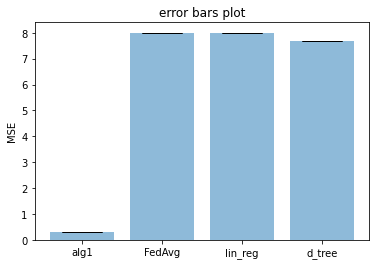

In [37]:
labels = ['alg1', 'FedAvg', 'lin_reg', 'd_tree']
x_pos = np.arange(len(labels))
    
    
print('algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in alg1_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in alg1_scores]))

print('federated learning:', 
      '\n mean train MSE:', np.mean([item['train'] for item in fl_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in fl_scores])) 
                                                                         
print('linear regression:', 
      '\n mean train MSE:', np.mean([item['train'] for item in linear_regression_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in linear_regression_scores]))

print('decision tree:', 
      '\n mean train MSE:', np.mean([item['train'] for item in decision_tree_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in decision_tree_scores]))
    
alg1_norm1_score = [item['total'] for item in alg1_scores]
fl_score = [item['total'] for item in fl_scores]  
linear_regression_score = [item['total'] for item in linear_regression_scores]
decision_tree_score = [item['total'] for item in decision_tree_scores]

mean_MSEs = [
    np.mean(alg1_norm1_score), 
    np.mean(fl_score), 
    np.mean(linear_regression_score), 
    np.mean(decision_tree_score)
]

std_MSEs = [
    np.std(alg1_norm1_score), 
    np.std(fl_score),
    np.std(linear_regression_score), 
    np.std(decision_tree_score)
]


fig, ax = plt.subplots()
ax.bar(x_pos, mean_MSEs,
   yerr=std_MSEs,
   align='center',
   alpha=0.5,
   ecolor='black',
   capsize=20)
ax.set_ylabel('MSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
# ax.set_yscale('log')
ax.set_title('error bars plot')
plt.show()
plt.close()
    

For this case the results of our primal-dual algorithm is:

algorithm 1, norm1:

 mean train MSE: 6.667142357839366e-06
 
 mean test MSE: 7.223684892899274e-06

## Results 

### Number of features: 1
### Number of datapoints per node: 100

In [38]:
import random 
import matplotlib.pyplot as plt

from collections import defaultdict


PENALTY_FUNCS = ['norm1', 'norm2', 'mocha']

LAMBDA_LASSO = {'norm1': 0.1, 'norm2': 0.01, 'mocha': 0.05}

K = 1000

B, weight_vec, true_labels, datapoints = get_sbm_2blocks_data(m=100, n=1, pin=1.0, pout=0.01)
E, N = B.shape

alg1_scores = []
fl_scores = []
linear_regression_scores = []
decision_tree_scores = []

num_tries = 5
num_tries = 1

from joblib import Parallel, delayed
import multiprocessing
def fun():
    samplingset = random.sample([j for j in range(N)], k=int(0.8* N)) 
    lambda_lasso = 0.1
    _, predicted_w = algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso)
    _, fl_w = fedAvg(K, datapoints, true_labels, samplingset)

    return get_scores(datapoints, predicted_w, fl_w, samplingset)


# results = Parallel(n_jobs=4)(delayed(fun)() 
#                                          for i in range(num_tries))

results = [fun()]

for scores in results:
    alg1_score, fl_score, linear_regression_score, decision_tree_score = scores
    alg1_scores.append(alg1_score)
    fl_scores.append(fl_score)
    linear_regression_scores.append(linear_regression_score)
    decision_tree_scores.append(decision_tree_score)


algorithm 1: 
 mean train MSE: 0.04421294244687085 
 mean test MSE: 0.06579087272618395
federated learning: 
 mean train MSE: 4.025069028390272 
 mean test MSE: 4.036943121486754
linear regression: 
 mean train MSE: 4.024627639884613 
 mean test MSE: 4.050266376842582
decision tree: 
 mean train MSE: 3.9673220640707605 
 mean test MSE: 4.0509968519714405


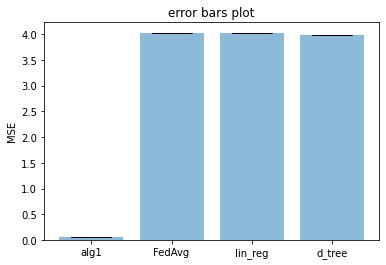

In [39]:
labels = ['alg1', 'FedAvg', 'lin_reg', 'd_tree']
x_pos = np.arange(len(labels))
    
    
print('algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in alg1_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in alg1_scores]))

print('federated learning:', 
      '\n mean train MSE:', np.mean([item['train'] for item in fl_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in fl_scores])) 
                                                                         
print('linear regression:', 
      '\n mean train MSE:', np.mean([item['train'] for item in linear_regression_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in linear_regression_scores]))

print('decision tree:', 
      '\n mean train MSE:', np.mean([item['train'] for item in decision_tree_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in decision_tree_scores]))
    
alg1_norm1_score = [item['total'] for item in alg1_scores]
fl_score = [item['total'] for item in fl_scores]  
linear_regression_score = [item['total'] for item in linear_regression_scores]
decision_tree_score = [item['total'] for item in decision_tree_scores]

mean_MSEs = [
    np.mean(alg1_norm1_score), 
    np.mean(fl_score), 
    np.mean(linear_regression_score), 
    np.mean(decision_tree_score)
]

std_MSEs = [
    np.std(alg1_norm1_score), 
    np.std(fl_score),
    np.std(linear_regression_score), 
    np.std(decision_tree_score)
]


fig, ax = plt.subplots()
ax.bar(x_pos, mean_MSEs,
   yerr=std_MSEs,
   align='center',
   alpha=0.5,
   ecolor='black',
   capsize=20)
ax.set_ylabel('MSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
# ax.set_yscale('log')
ax.set_title('error bars plot')
plt.show()
plt.close()
    

## Results 

### Number of features: 10
### Number of datapoints per node: 100

In [41]:
import random 
import matplotlib.pyplot as plt

from collections import defaultdict


PENALTY_FUNCS = ['norm1', 'norm2', 'mocha']

LAMBDA_LASSO = {'norm1': 0.1, 'norm2': 0.01, 'mocha': 0.05}

K = 1000

B, weight_vec, true_labels, datapoints = get_sbm_2blocks_data(m=100, n=10, pin=1.0, pout=0.01)
E, N = B.shape

alg1_scores = []
fl_scores = []
linear_regression_scores = []
decision_tree_scores = []

num_tries = 5
num_tries = 1

from joblib import Parallel, delayed
import multiprocessing
def fun():
    samplingset = random.sample([j for j in range(N)], k=int(0.8* N)) 
    lambda_lasso = 0.1
    _, predicted_w = algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso)
    _, fl_w = fedAvg(K, datapoints, true_labels, samplingset)

    return get_scores(datapoints, predicted_w, fl_w, samplingset)


# results = Parallel(n_jobs=4)(delayed(fun)() 
#                                          for i in range(num_tries))

results = [fun()]

for scores in results:
    alg1_score, fl_score, linear_regression_score, decision_tree_score = scores
    alg1_scores.append(alg1_score)
    fl_scores.append(fl_score)
    linear_regression_scores.append(linear_regression_score)
    decision_tree_scores.append(decision_tree_score)



algorithm 1: 
 mean train MSE: 0.4507105340470756 
 mean test MSE: 0.6245521785795568
federated learning: 
 mean train MSE: 39.456262429978466 
 mean test MSE: 41.30888083244759
linear regression: 
 mean train MSE: 39.42437191349708 
 mean test MSE: 41.303245255342866
decision tree: 
 mean train MSE: 39.28612309856595 
 mean test MSE: 41.206450317506956


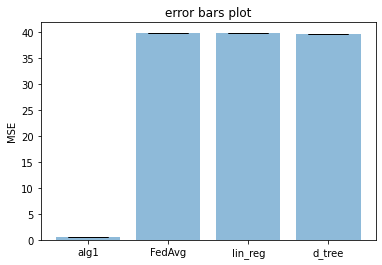

In [42]:
labels = ['alg1', 'FedAvg', 'lin_reg', 'd_tree']
x_pos = np.arange(len(labels))
    
    
print('algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in alg1_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in alg1_scores]))

print('federated learning:', 
      '\n mean train MSE:', np.mean([item['train'] for item in fl_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in fl_scores])) 
                                                                         
print('linear regression:', 
      '\n mean train MSE:', np.mean([item['train'] for item in linear_regression_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in linear_regression_scores]))

print('decision tree:', 
      '\n mean train MSE:', np.mean([item['train'] for item in decision_tree_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in decision_tree_scores]))
    
alg1_norm1_score = [item['total'] for item in alg1_scores]
fl_score = [item['total'] for item in fl_scores]  
linear_regression_score = [item['total'] for item in linear_regression_scores]
decision_tree_score = [item['total'] for item in decision_tree_scores]

mean_MSEs = [
    np.mean(alg1_norm1_score), 
    np.mean(fl_score), 
    np.mean(linear_regression_score), 
    np.mean(decision_tree_score)
]

std_MSEs = [
    np.std(alg1_norm1_score), 
    np.std(fl_score),
    np.std(linear_regression_score), 
    np.std(decision_tree_score)
]


fig, ax = plt.subplots()
ax.bar(x_pos, mean_MSEs,
   yerr=std_MSEs,
   align='center',
   alpha=0.5,
   ecolor='black',
   capsize=20)
ax.set_ylabel('MSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
# ax.set_yscale('log')
ax.set_title('error bars plot')
plt.show()
plt.close()
    

## Results 

### Number of features: 50
### Number of datapoints per node: 100

In [43]:
import random 
import matplotlib.pyplot as plt

from collections import defaultdict


PENALTY_FUNCS = ['norm1', 'norm2', 'mocha']

LAMBDA_LASSO = {'norm1': 0.1, 'norm2': 0.01, 'mocha': 0.05}

K = 1000

B, weight_vec, true_labels, datapoints = get_sbm_2blocks_data(m=100, n=50, pin=1.0, pout=0.01)
E, N = B.shape

alg1_scores = []
fl_scores = []
linear_regression_scores = []
decision_tree_scores = []

num_tries = 5
num_tries = 1

from joblib import Parallel, delayed
import multiprocessing
def fun():
    samplingset = random.sample([j for j in range(N)], k=int(0.8* N)) 
    lambda_lasso = 0.1
    _, predicted_w = algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso)
    _, fl_w = fedAvg(K, datapoints, true_labels, samplingset)

    return get_scores(datapoints, predicted_w, fl_w, samplingset)


# results = Parallel(n_jobs=4)(delayed(fun)() 
#                                          for i in range(num_tries))

results = [fun()]

for scores in results:
    alg1_score, fl_score, linear_regression_score, decision_tree_score = scores
    alg1_scores.append(alg1_score)
    fl_scores.append(fl_score)
    linear_regression_scores.append(linear_regression_score)
    decision_tree_scores.append(decision_tree_score)




algorithm 1: 
 mean train MSE: 2.201063308449209 
 mean test MSE: 3.5800397170437908
federated learning: 
 mean train MSE: 202.6317943451846 
 mean test MSE: 208.7041774412363
linear regression: 
 mean train MSE: 201.79048287213618 
 mean test MSE: 212.48123201966442
decision tree: 
 mean train MSE: 203.52845280758368 
 mean test MSE: 199.99066528291846


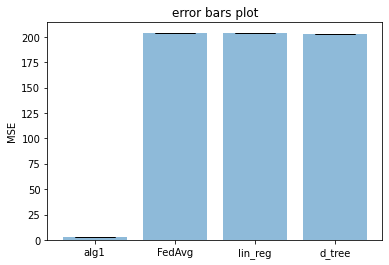

In [44]:
labels = ['alg1', 'FedAvg', 'lin_reg', 'd_tree']
x_pos = np.arange(len(labels))
    
    
print('algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in alg1_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in alg1_scores]))

print('federated learning:', 
      '\n mean train MSE:', np.mean([item['train'] for item in fl_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in fl_scores])) 
                                                                         
print('linear regression:', 
      '\n mean train MSE:', np.mean([item['train'] for item in linear_regression_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in linear_regression_scores]))

print('decision tree:', 
      '\n mean train MSE:', np.mean([item['train'] for item in decision_tree_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in decision_tree_scores]))
    
alg1_norm1_score = [item['total'] for item in alg1_scores]
fl_score = [item['total'] for item in fl_scores]  
linear_regression_score = [item['total'] for item in linear_regression_scores]
decision_tree_score = [item['total'] for item in decision_tree_scores]

mean_MSEs = [
    np.mean(alg1_norm1_score), 
    np.mean(fl_score), 
    np.mean(linear_regression_score), 
    np.mean(decision_tree_score)
]

std_MSEs = [
    np.std(alg1_norm1_score), 
    np.std(fl_score),
    np.std(linear_regression_score), 
    np.std(decision_tree_score)
]


fig, ax = plt.subplots()
ax.bar(x_pos, mean_MSEs,
   yerr=std_MSEs,
   align='center',
   alpha=0.5,
   ecolor='black',
   capsize=20)
ax.set_ylabel('MSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
# ax.set_yscale('log')
ax.set_title('error bars plot')
plt.show()
plt.close()
    